# Parameter Exploration

This notebook explores how network parameters impact the match between simulated functional connectivity (FC) and an empirical target FC.

What you will see:
- Load an HCP dataset and compute a target FC.
- Define a Wilson–Cowan network with delayed, diffusive coupling and stochastic inputs.
- Run simulations to obtain FC and measure correlation with the target.
- Explore parameters in two ways: (1) grid search with `jit` + `vmap`, and (2) black‑box optimization via Nevergrad.

Key parameters:
- `k` (global coupling gain): scales inter‑regional coupling strength.
- `sigma` (noise scale): controls OU noise magnitude on E/I populations.
- `signal_speed` (m/s equivalent): affects inter‑regional delays via structural distances.

Performance notes:
- Simulations are vectorized with `jax.vmap` and compiled with `jax.jit` for speed.
- FC computation and grid sweeps are memory intensive; reduce grid size on limited hardware.

In [4]:
import brainstate
import braintools
import brainmass
import brainunit as u
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [5]:
brainstate.environ.set(dt=0.1 * u.ms)

In [6]:
import os.path
import kagglehub
path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
data = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

target_fc = [braintools.metric.functional_connectivity(x.T) for x in data['BOLDs']]
target_fc = jnp.mean(jnp.asarray(target_fc), axis=0)

Loading checkpoint from D:\Data\kagglehub\datasets\oujago\hcp-gw-data-samples\versions\1\hcp-data-sample.msgpack


Environment and data:
- `dt` sets the simulation time step (here 0.1 ms).
- We load the `hcp` dataset (structural matrices `Cmat` for coupling and `Dmat` for distances, plus BOLD timeseries).
- The target FC is the mean across subjects of pairwise correlations on BOLD signals. This will be our fitting target.

In [7]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1., sigma=0.01):
        super().__init__()

        conn_weight = data['Cmat'].copy()
        np.fill_diagonal(conn_weight, 0)
        delay_time = data['Dmat'].copy() / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.arange(conn_weight.shape[1])
        indices_ = np.tile(np.expand_dims(indices_, axis=0), (conn_weight.shape[0], 1))

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=sigma, init=brainstate.init.ZeroInit()),
            noise_I=brainmass.OUProcess(80, sigma=sigma, init=brainstate.init.ZeroInit()),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time * u.ms, indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

Model overview:
- Node dynamics: a Wilson–Cowan unit with E/I populations and OU noise (`sigma` controls noise scale).
- Delays: derived from structural distances `Dmat` and `signal_speed` (ms); used via `prefetch_delay` on the E‑rate.
- Coupling: diffusive coupling takes delayed E activity from other nodes, scales by `k`, and injects it as current.
- `step_run(i)`: advances one step while maintaining correct time/index context.

In [8]:
def simulation(k, sigma):
    net = Network(k=k, sigma=sigma)
    brainstate.nn.init_all_states(net)
    indices = np.arange(0, 6e3 * u.ms // brainstate.environ.get_dt())
    exes = brainstate.transform.for_loop(net.step_run, indices)
    fc = braintools.metric.functional_connectivity(exes)
    return braintools.metric.matrix_correlation(target_fc, fc)

## Grid Search
We sweep `k` and `sigma` over user‑defined ranges and evaluate correlation between simulated and target FC.

How it works:
- Define grids `all_ks` and `all_sigmas`.
- Vectorize `simulation(k, sigma)` across both axes with nested `jax.vmap`.
- Compile with `jax.jit` to amortize overhead across the grid evaluation.
- Use `jax.block_until_ready` to ensure all computations complete before plotting.

Practical tips:
- Start with a coarse grid to locate promising regions; refine around peaks.
- This step is memory hungry. Reduce grid size or simulation length if you see OOM.
- Consider fixing `signal_speed` first, then scanning `k`/`sigma`.

In [9]:
all_ks = jnp.linspace(0.5, 3.0, 4)
all_sigmas = jnp.linspace(0.01, 0.2, 4)

In [10]:
@brainstate.transform.jit
def parameter_exploration(ks, sigmas):
    results = brainstate.transform.vmap(
        lambda k: brainstate.transform.vmap(lambda sigma: simulation(k, sigma))(sigmas)
    )(ks)
    return results

## Black‑Box Optimization
Instead of scanning a 2D grid, you can optimize a subset of parameters with a black‑box optimizer.
Here we fix `sigma` and minimize `1 - correlation` over `k` using Nevergrad's Differential Evolution (DE).

Notes:
- We wrap `simulation` in a `vmap`‑compatible loss (`vmap_loss_fn`) so the optimizer can evaluate minibatches.
- Bounds constrain the search; `n_sample` and `n_iter` control evaluation budget.
- For multi‑param optimization, extend bounds (e.g., `{'k': [..], 'sigma': [..]}`) and adapt the loss accordingly.

In [11]:
correlations = jax.block_until_ready(parameter_exploration(all_ks, all_sigmas))

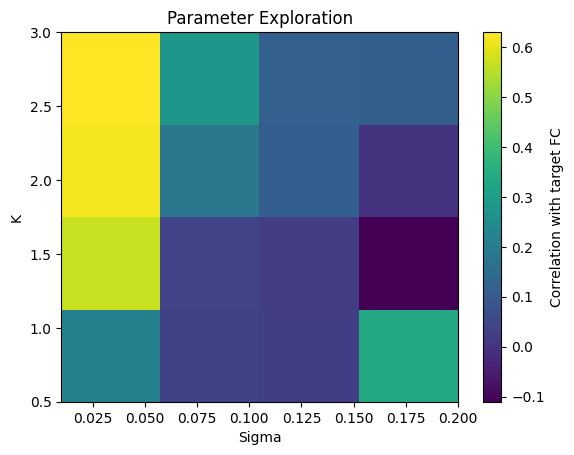

In [12]:
plt.imshow(correlations, extent=(all_sigmas[0], all_sigmas[-1], all_ks[0], all_ks[-1]), origin='lower', aspect='auto')
plt.colorbar(label='Correlation with target FC')
plt.xlabel('Sigma')
plt.ylabel('K')
plt.title('Parameter Exploration')
plt.show()

## Parameter Optimization with Nevergrad

[nevergrad](https://github.com/facebookresearch/nevergrad) is a Python toolbox for performing gradient-free optimization.

In [13]:
@brainstate.transform.jit
def vmap_loss_fn(k):
    return 1 - brainstate.transform.vmap(lambda x: simulation(x, sigma=0.05))(k)

In [14]:
opt = braintools.optim.NevergradOptimizer(
    vmap_loss_fn, method='DE', n_sample=4, bounds={'k': [0.5, 3.0]}
)
opt.initialize()
opt.minimize(n_iter=10)


Iteration 0, best error: 0.81766, best parameters: {'k': 1.8951946131541637}
Iteration 1, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 2, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 3, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 4, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 5, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 6, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 7, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 8, best error: 0.59299, best parameters: {'k': 2.8479640056145596}
Iteration 9, best error: 0.59299, best parameters: {'k': 2.8479640056145596}


{'k': 2.8479640056145596}